In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pydrake.geometry import (
    FramePoseVector,
    GeometryFrame,
    GeometryInstance,
    MakePhongIllustrationProperties,
    MeshcatVisualizer,
    SceneGraph,
    Sphere,
    StartMeshcat
)

from pydrake.math import (
    RigidTransform
)

from pydrake.systems.framework import (
    DiagramBuilder,
    LeafSystem,
    UnrestrictedUpdateEvent,
    WitnessFunctionDirection
)

from pydrake.systems.primitives import LogVectorOutput
from pydrake.common.value import Value
from pydrake.systems.analysis import Simulator, SimulatorConfig, ApplySimulatorConfig

In [2]:
class BouncingBall(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.
        
        self.__restitution_coef = 1.0
        self.__viscous_friction = 0.2
        
        state_index = self.DeclareContinuousState(1,1,0)  #q=1, v=1, z=0
        #self.DeclareStateOutputPort(kUseDefaultName, state_index)
        self.DeclareStateOutputPort('y', state_index)

        self.signed_distance_witness = self.MakeWitnessFunction(
            "Signed distance", 
            WitnessFunctionDirection.kPositiveThenNonPositive,
            self.CalcSignedDistance,
            UnrestrictedUpdateEvent(self.reset)
        )
    
    def CalcSignedDistance(self, context):
        xc = context.get_continuous_state_vector()
        return float(xc.GetAtIndex(0))
    
    def get_gravitational_acceleration(self):
        return float(-9.81)
    
    def get_restitution_coef(self):
        return self.__restitution_coef
    
    def get_viscous_friction(self):
        return self.__viscous_friction
    
    #def DoCalcUnrestrictedUpdate(self, context, next_state)        
    def reset(self, context, event, next_state):
        
        next_state.get_mutable_continuous_state().get_mutable_vector().SetAtIndex(
            1, context.get_continuous_state().get_vector().GetAtIndex(1) * self.get_restitution_coef() * -1.0)     
        
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        state = context.get_continuous_state_vector()
        
        # Time derivative of position (state index 0) is velocity.
        derivatives.get_mutable_vector().SetAtIndex(
            0, state.GetAtIndex(1)
        )
        
        # Time derivative of velocity (state index 1) is acceleration.
        derivatives.get_mutable_vector().SetAtIndex(
            1, self.get_gravitational_acceleration() - self.get_viscous_friction()*state.GetAtIndex(1)
        )
        
        
    def SetDefaultState(self, context, state):
        xc0 = np.array([10.0, 0.0])
        state.get_mutable_continuous_state().SetFromVector(xc0)
        
    def DoGetWitnessFunctions(self, context):
        # RETURN the self.signed_distance_witness object
        # NOT THE FUNCTION CalcSignedDistance!!
        return [self.signed_distance_witness]

In [3]:
ball_system = BouncingBall()

builder = DiagramBuilder()
builder.AddSystem(ball_system)
logger = LogVectorOutput(ball_system.GetOutputPort('y'), builder)
builder.ExportOutput(ball_system.GetOutputPort('y'))
diagram = builder.Build()

ics = [10.0, 0.0]

simulator = Simulator(diagram)

simconf = SimulatorConfig(accuracy=1e-10, max_step_size=0.01, integration_scheme='runge_kutta5')
ApplySimulatorConfig(simconf, simulator)

sim_context = simulator.get_mutable_context()

# Set the initial conditions:
sim_context.SetTime(0.0)
sim_context.SetContinuousState(ics)
sim_context.SetAccuracy(1e-10)

print("Simulating with ics: ", ics)

# Run the simulation forward.
simulator.AdvanceTo(20.0)

Simulating with ics:  [10.0, 0.0]


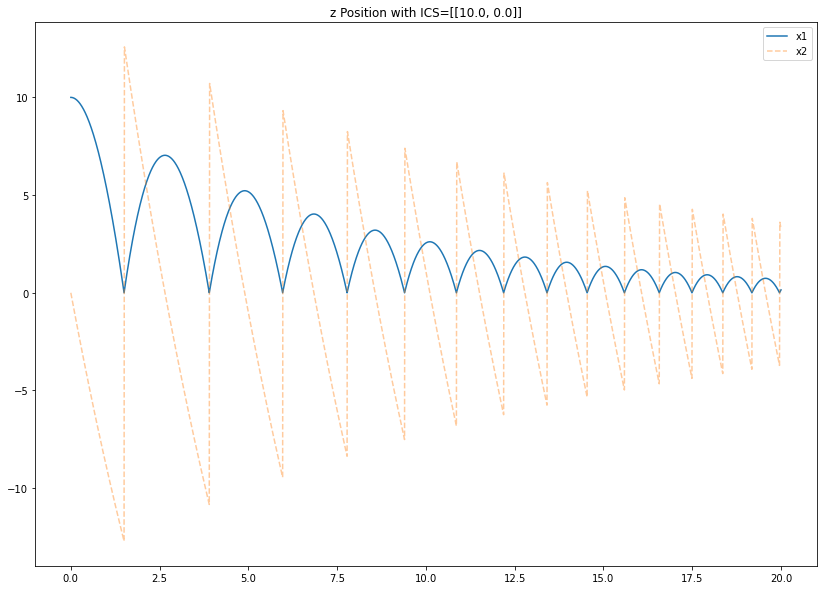

In [4]:
log = logger.FindLog(sim_context)

# Specify the figure size
plt.figure(figsize=(14, 10))

plt.title("z Position with ICS=["+str(ics)+"]")
plt.plot(log.sample_times(), log.data()[0], label="x1")
plt.plot(log.sample_times(), log.data()[1], "--", alpha=0.4, label="x2")
plt.legend()
plt.show()


# Meshcat viz:

In [5]:
class BouncingBallGeometry(LeafSystem):
    
    def __init__(self, scene_graph):
        super().__init__()  # Don't forget to initialize the base class.
        self.x_port = self.DeclareVectorInputPort("state", 2)
        
        self.frame_id0 = scene_graph.RegisterFrame(_id, GeometryFrame("f0"))
        
        # Make some geometry, and set initial (geom) positions:
        _sphere = GeometryInstance(RigidTransform([0, 0, 0.5]), Sphere(0.5), "sphere_instance")

        scene_graph.AssignRole(_id, scene_graph.RegisterGeometry(_id, self.frame_id0, _sphere), MakePhongIllustrationProperties(np.array([.9, .1, 0, 1]).T))

        self.DeclareAbstractOutputPort("geometry_pose",
                                    alloc=lambda: Value(FramePoseVector()),
                                    calc=self.OutputGeometryPose)
        
        
    def OutputGeometryPose(self, context, framePoseVec):
        x = self.x_port.Eval(context)
        
        X1 = RigidTransform([0, 0, x[0]])
        
        # Unpack FramePoseVector, and set values from state (input to geometry)
        FPV = framePoseVec.get_value()
        FPV.set_value(self.frame_id0, X1)

In [6]:
meshcat = StartMeshcat()

scene_graph = SceneGraph()
_id = scene_graph.RegisterSource("source")

ball_system = BouncingBall()
ball_system_geom = BouncingBallGeometry(scene_graph)

builder = DiagramBuilder()
builder.AddSystem(scene_graph)
builder.AddSystem(ball_system)
builder.AddSystem(ball_system_geom)

# Connect system output to geom_input, and geom_ouput to scenegraph pose input.
builder.Connect(ball_system.GetOutputPort('y'),  ball_system_geom.get_input_port())
builder.Connect(ball_system_geom.GetOutputPort("geometry_pose"),  scene_graph.get_source_pose_port(_id))

# Convenience function to add meshcat to builder
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Display Meshcat in Notebook:

In [7]:
from IPython.display import IFrame
address = meshcat.web_url()
print("Or, just view it here in the browser...")
display(IFrame(src=address, width='100%', height='800px'))

ics = [10, 0]

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()
sim_context.SetTime(0)
sim_context.SetContinuousState(ics)
sim_context.SetAccuracy(1e-10)      #<--- hybrid model needs this.

simulator.set_target_realtime_rate(1.5)

#print("Use the slider in the MeshCat controls to apply elbow torque.")
print("Press 'Stop Simulation' in MeshCat to continue.")
meshcat.AddButton("Stop Simulation")
while meshcat.GetButtonClicks("Stop Simulation") < 1:
    simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)

meshcat.DeleteAddedControls()

Or, just view it here in the browser...


Press 'Stop Simulation' in MeshCat to continue.


### Add a boolean indicator for resting on ground to avoid the numerical challenges of simulation around the Zeno phenomenon at the resting fixed point...